In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input
from tifffile import imwrite

from datagenerator_3D import stack_generator, data_generator
# from model_3D_interconnect import make_generator
from model_3D import make_generator

1 Physical GPUs, 1 Logical GPUs


In [ ]:
aa = imread(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\1\1frame.tif').astype(np.float64)
aa[aa>25000] = 0
for i in range(len(aa)):
    if aa[i].max()>0:
        aa[i] = aa[i]/aa[i].max()
aa = (aa*(2**16-1)).astype(np.uint16)
imwrite(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\1\1framem.tif',aa, imagej=True, metadata={'axes': 'TZYX'})


In [26]:
test_GT = r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\1frame'
test_low = r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\1frame'
model_save_directory = r"D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\patches\mitochondria_3D_2.h5"



test_patch_size=512
frame_start=30
frame_end =46
n_channel = 0
n_patches=1


# filters =[32,64,128]
filters =[16,32]
filters1 = [80,160]
num_filters = filters1[0]
filters_cab=num_filters/16
# num_RG=3
# num_RCAB=8

num_RG=4
num_RCAB=4

gt_test,low_test=stack_generator(test_GT,test_low, fr_start=frame_start,fr_end=frame_end)
x_test, y_test,_,_ = data_generator(gt_test, low_test, test_patch_size, n_patches=n_patches,
                                    n_channel=n_channel, threshold=0, ratio=1.0,lp = 10.0,
                                    fr_start=frame_start,fr_end=frame_end,augment=False, shuffle=True, add_noise=False)

generator_input = Input((test_patch_size, test_patch_size,frame_end-frame_start,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=3,dropout=0.4)

generator.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
prediction2 = np.zeros(x_test.shape)

for i in range(len(x_test)):
    prediction1[i],prediction2[i]= generator(x_test[i:i+1],training=False)
#     prediction1[i] = prediction1[i]/prediction1[i].max()
#     prediction2[i] = prediction2[i]/prediction2[i].max()

prediction1 = prediction1/prediction1.max()
prediction2= prediction2/prediction2.max()
prediction1[prediction1<0]=0
prediction2[prediction2<0]=0

mip_x_test=np.max(x_test,axis=3)
mip_y_test=np.max(y_test,axis=3)
mip_prediction1=np.max(prediction1,axis=3)
mip_prediction2=np.max(prediction2,axis=3)

(16, 64, 1, 512, 512)
(16, 512, 512, 16, 1)
16
The training set shape is: (16, 512, 512, 16, 1)
The validation set shape is: (0, 512, 512, 16, 1)


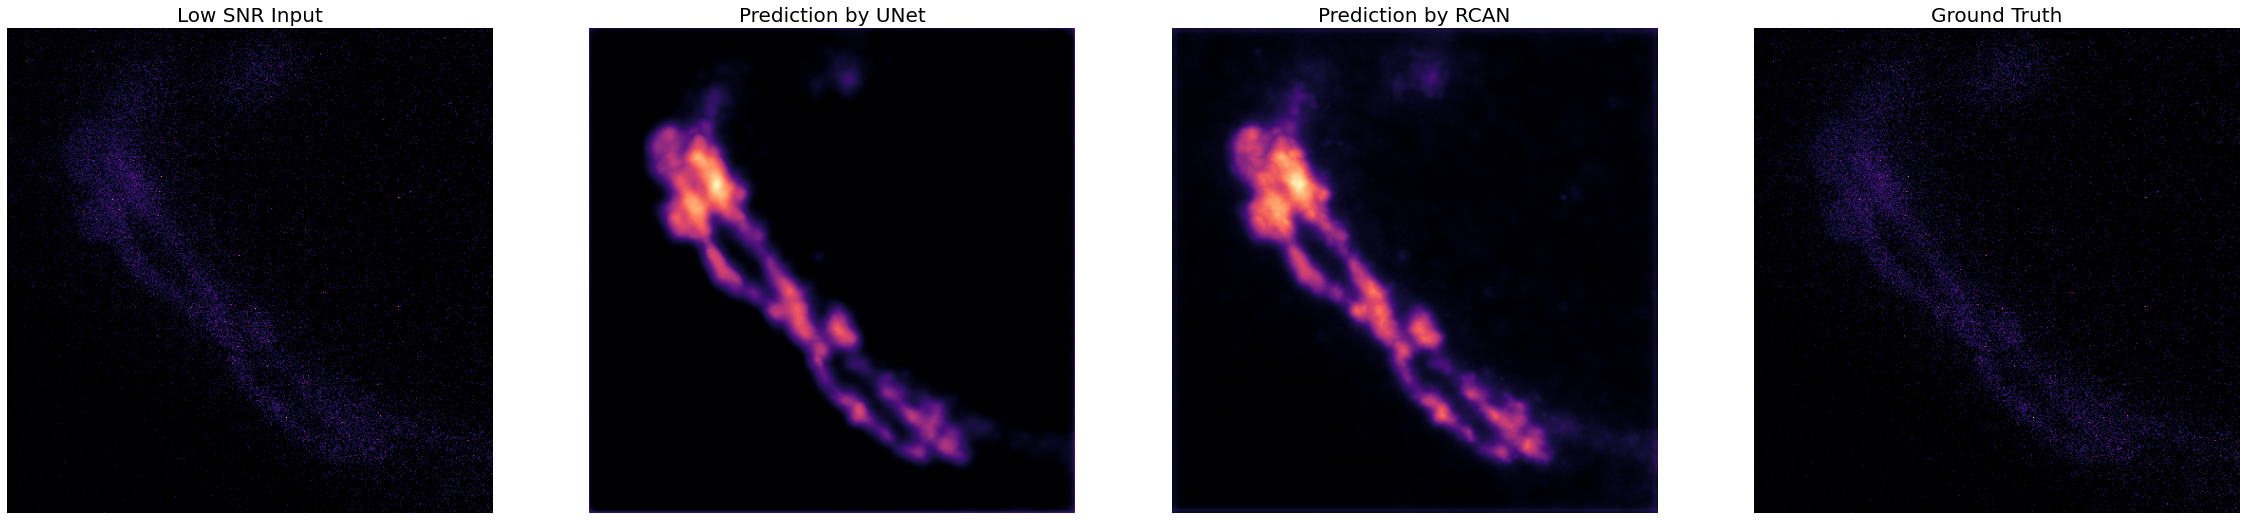

In [27]:
ix = np.random.randint(len(mip_prediction1))
# ix = image_number
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 4, 1)
plt.imshow(mip_x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mip_prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mip_prediction2[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by RCAN',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(mip_y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [28]:
save_image_dr = r"D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR" 

pred1_test = np.moveaxis(prediction2,3,1)
X_test = np.moveaxis(x_test,3,1)
Y_test = np.moveaxis(y_test,3,1)


pred1_test = pred1_test*(2**16-1)
X_test = X_test*(2**16-1)
Y_test = Y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/pred4.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
# imwrite(save_image_dr+'/noisy2.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
# imwrite(save_image_dr+'/gt2.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})

In [ ]:
pp = r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\test\noisy'
import os
a1 = imread(r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\3D STED_TOM20\noisy.tif')
for i in range(len(a1)):
    imwrite(os.path.join(pp,'',str(i)+'.tif'),a1[i].squeeze(),imagej=True,metadata={'axes': 'ZYX'})

In [ ]:
b1 = imread(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\pred1.tif')
b2 = imread(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\pred2.tif')
b3 = imread(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\pred3.tif')
b4 = imread(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\pred4.tif')
b = np.concatenate((b1,b2,b3,b4),axis=1)
imwrite(r'D:\Projects\Denoising-STED\20220913-RPI\3D STED\low SNR\pred.tif',b,imagej=True,metadata={'axes': 'TZYX'})

In [ ]:
save_parameters_dr = "/content/drive/MyDrive/WidefieldData/deconvolution/lp50/Parameters50ch1.csv"

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction, gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(mip_x_test,mip_y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(mip_prediction2,mip_y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE')

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR')

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM')


# np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")